# Inpainting with homogeneous diffusion 
We will use the inpainting with Homogeneous diffusion to interpolate in a grid. The method is described in https://arxiv.org/pdf/1506.04566.pdf. We consider the following PDE with mixed boundary conditions
$$\begin{align}
\nabla u &= 0 \text{ on } \Omega \setminus \Omega_{K}\,, \\
u &= f  \text{ on } \Omega_K \,, \\
\partial_n u &= 0 \text{ on } \partial \Omega \setminus \partial \Omega_K\,.
\end{align}$$

Here $ \partial_n u $ denotes the outward normal.

We will now try to use Laplace interpolation on an 1D problem. We will use the following function:

$f(x) = \exp{(2x -3)} + x\,,\quad x\in [-4, 4]\, $.

In [3]:
using Laplacians, LinearAlgebra, SparseArrays
using TestImages, Colors, Plots, FileIO

In [4]:
x_array = -4:0.08:4;
x_array = collect(x_array);
N = length(x_array);
f_array = exp.(2*x_array .- 3) + x_array;
discard = rand(2:100, 30);
discard = unique(discard);
all = collect(1:length(x_array));
keep = setdiff(all, discard);
length(keep);

In [5]:
#Constructing the Laplace matrix
h = 0.08;
ev = 1/h^2*ones(N-1,1);
dv = -ones(N,1)*2/h^2
A = Tridiagonal([fill(1.0/h^2, N-2); 0.0], [1.0; fill(-2.0/h^2, N-2); 1.0], [0.0; fill(1.0/h^2, N-2);]);

In [6]:
#Constructing C
diag_c = ones(N);
diag_c[discard] .= 0;
C = diagm(diag_c);
Id = Matrix(1.0I, N,N);

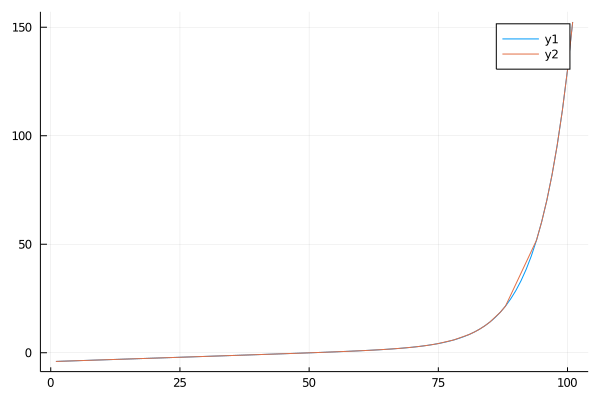

In [7]:
u = (C-(Id -C)*A)\(C*f_array);
pa = plot(f_array)
plot!(pa, u)


In [8]:
#Verifying if the second derivative at the discarded points is 0
(A*u)[discard];

# 2D Example
We will use the Mandrill image to test the approach.


In [9]:
img = testimage("mandrill");
imgg = Gray.(img);
mat = convert(Array{Float64}, imgg)[1:256,1:512];
# This image is square
#plot(imgg)

In [10]:
rows = size(mat,1);
columns = size(mat,2);
BoundaryNodes1 = collect(1:rows);
BoundaryNodes2 = collect(rows+1:rows:rows*columns-rows+1);
BoundaryNodes3 = collect(rows*columns-rows+2:rows*columns);
BoundaryNodes4 = collect(2*rows:rows:(columns-1)*rows);
BoundaryNodes= union(BoundaryNodes1, BoundaryNodes2, BoundaryNodes3, BoundaryNodes4);
AllNodes = collect(1:rows*columns)
NonBoundaryNodes = setdiff(AllNodes, BoundaryNodes);
size(NonBoundaryNodes);

In [11]:
#Now we discard about 50% of the non boundary nodes
No_of_nodes_discarded = 60000
discard = rand(1:length(NonBoundaryNodes), No_of_nodes_discarded);
discard = unique(discard);
discard = NonBoundaryNodes[discard];

In [12]:
#Constructing the 2D Laplace matrix
function spdiagm_nonsquare(m, n, args...)
    I, J, V = SparseArrays.spdiagm_internal(args...)
    return sparse(I, J, V, m, n)
end

# returns -∇² (discrete Laplacian, real-symmetric positive-definite) on n₁×n₂ grid
function ∇²(n₁,n₂)
    o₁ = ones(n₁)
    ∂₁ = spdiagm_nonsquare(n₁+1,n₁,-1=>-o₁,0=>o₁)
    o₂ = ones(n₂)
    ∂₂ = spdiagm_nonsquare(n₂+1,n₂,-1=>-o₂,0=>o₂)
    return kron(sparse(I,n₂,n₂), ∂₁'*∂₁) + kron(∂₂'*∂₂, sparse(I,n₁,n₁))
end

∇² (generic function with 1 method)

In [13]:
A = ∇²(rows,columns);

In [14]:
#Enforcing Dirichlet Boundary conditions
A[BoundaryNodes,:] .= 0
A[:,BoundaryNodes] .= 0
A[BoundaryNodes, BoundaryNodes] = sparse(I, length(BoundaryNodes), length(BoundaryNodes));
A;

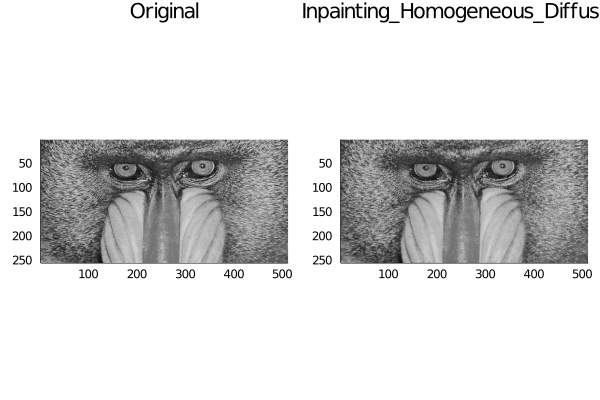

In [15]:
#Constructing C
C = sparse(I, rows*columns, rows*columns)
C[discard,discard] .= 0
Id = sparse(I, rows*columns,rows*columns);
f = mat[:];
u =((C-(Id -C)*A)) \ (C*f);
restored_img = reshape(u, size(mat,1), size(mat,2));
pa = plot(Gray.(restored_img), title="Inpainting_Homogeneous_Diffusion")
plot(plot(imgg[1:size(mat,1),1:size(mat,2)], title="Original"),pa,  layout = (1,2))

In [16]:
A_new  = ∇²(rows,columns);
sum((A_new*u)[discard] .< 1e-6) == length(discard);

In [17]:
norm(mat[:] - u)

19.246723963095675

# Adding holes to the Mandrill Image

In [18]:
cent = [(100, 200), (200, 100), (400, 200)]
c = cent[1]
rad = 20

L = 1:size(mat,1)
K = 1:size(mat,2)

mask = ones(size(mat))
mask = broadcast(+, (L .- c[1]).^2, (K .- c[2])'.^2) .> rad^2

keep = collect(1:prod(size(mat)))

fun(c, k) = filter(x -> (floor(x/size(mat,1)) .- c[1]).^2 + (x%size(mat,1) .- c[2])'.^2 > rad^2, k)

keep = fun(cent[1], keep)
keep = fun(cent[2], keep)
keep = fun(cent[3], keep)

prod(size(mask)) - sum(mask[keep]), 2*20^2*pi;

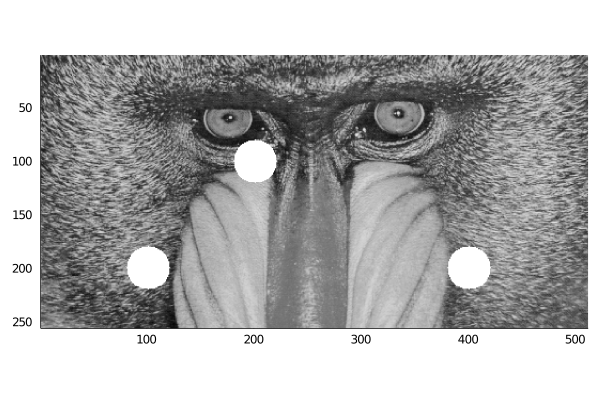

In [19]:
S = [i*size(mat,2)+j for i in 0:(size(mat,1)-1) for j in 1:size(mat,2)]
vals = mat[:]
holeyimage = ones(size(mat,1),size(mat,2))
holeyimage[S[keep]] = vals[keep]
plot(Gray.(holeyimage))

In [20]:
discard = setdiff(AllNodes, keep);

  0.065265 seconds (101 allocations: 84.275 MiB, 17.10% gc time)


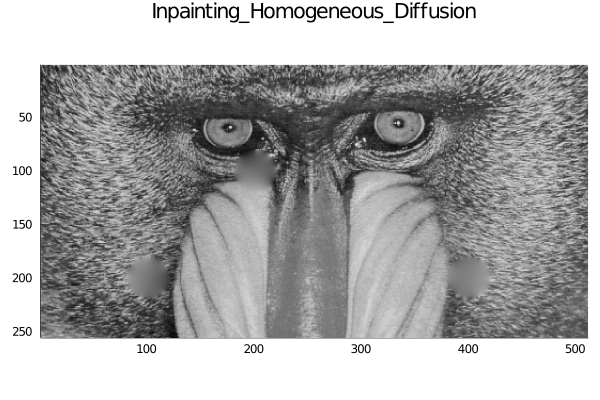

In [21]:
C = sparse(I, rows*columns, rows*columns)
C[discard,discard] .= 0
Id = sparse(I, rows*columns,rows*columns);
f = mat[:];
@time u =((C-(Id -C)*A)) \ (C*f);
restored_img = reshape(u, size(mat,1), size(mat,2));
plot(Gray.(restored_img), title="Inpainting_Homogeneous_Diffusion")


In [22]:
sum((A_new*u)[discard] .< 1e-6) == length(discard);

In [23]:
#Constructing the 3D Laplace matrix
function spdiagm_nonsquare(m, n, args...)
    I, J, V = SparseArrays.spdiagm_internal(args...)
    return sparse(I, J, V, m, n)
end

# returns -∇² (discrete Laplacian, real-symmetric positive-definite) on n₁×n₂ grid
function ∇²3d(n₁,n₂,n3)
    o₁ = ones(n₁)
    ∂₁ = spdiagm_nonsquare(n₁+1,n₁,-1=>-o₁,0=>o₁)
    o₂ = ones(n₂)
    ∂₂ = spdiagm_nonsquare(n₂+1,n₂,-1=>-o₂,0=>o₂)
    O3 = ones(n3)
    del3 = spdiagm_nonsquare(n3+1,n3,-1=>-O3,0=>O3)
    return kron(sparse(I,n3,n3),sparse(I,n₂,n₂), ∂₁'*∂₁) + kron(sparse(I,n3,n3), ∂₂'*∂₂, sparse(I,n₁,n₁)) + kron(del3'*del3, sparse(I,n₂,n₂), sparse(I,n₁,n₁))
end

∇²3d (generic function with 1 method)

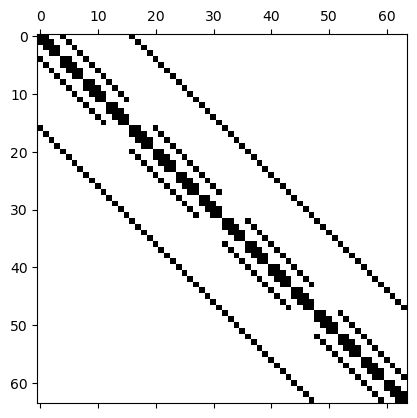

PyObject <matplotlib.image.AxesImage object at 0x1578df850>

In [24]:
A3D = ∇²3d(4,4,4);
using PyPlot
PyPlot.spy(A3D)

We will now solve a simple Poisson problem $-\Delta u =  f $ with homogeneous Dirichlet boundary conditions to verify the correctness of our Laplace operator. We will use the method of manufactured solutions with $u = \sin(2 \pi x) \sin(2\pi y) \sin(2\pi z)$.

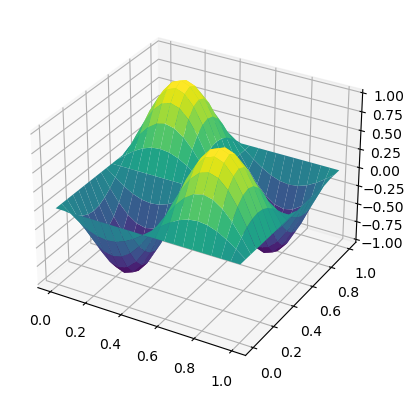

In [26]:
using VectorizedRoutines
h = 0.05
x_dir = collect(0:h:1);
y_dir = collect(0:h:1);
z_dir = collect(0:h:1);
xmesh, ymesh, zmesh = Matlab.meshgrid(x_dir, y_dir, z_dir);
u_true = sin.(2*pi*xmesh).*sin.(2*pi*ymesh).*sin.(2*pi*zmesh);
surf(xmesh[:,:,1], ymesh[:,:,1], u_true[:,:,16], cmap=ColorMap("viridis"));

In [27]:
ngrid = convert(Int64, 1/h+1);
rhs_f = -12*pi^2*sin.(2*pi*xmesh).*sin.(2*pi*ymesh).*sin.(2*pi*zmesh);
rhs_f = rhs_f[:];
A3D = -∇²3d(ngrid, ngrid, ngrid)/h^2;
u_approx = A3D\rhs_f;
u_approx = reshape(u_approx, ngrid, ngrid, ngrid);

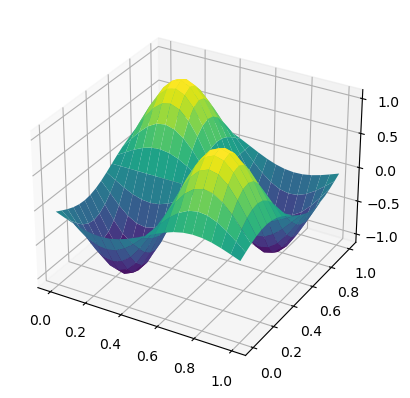

In [28]:
using VectorizedRoutines
x_dir = collect(0:0.05:1);
y_dir = collect(0:0.05:1);
z_dir = collect(0:0.05:1);
xmesh, ymesh, zmesh = Matlab.meshgrid(x_dir, y_dir, z_dir);
u_true = sin.(2*pi*xmesh).*sin.(2*pi*ymesh).*sin.(2*pi*zmesh);
surf(xmesh[:,:,1], ymesh[:,:,1], u_approx[:,:,16], cmap=ColorMap("viridis"));

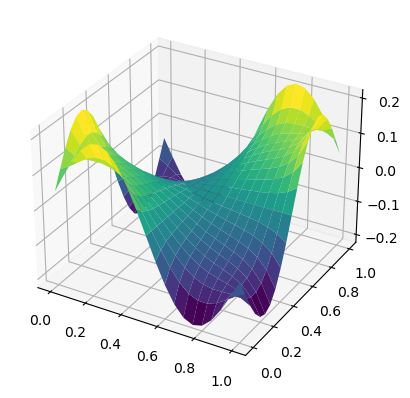

In [29]:
norm(u_approx[:] - u_true[:]);
error = reshape(u_true[:] -u_approx[:], 21,21,21);
surf(xmesh[:,:,1], ymesh[:,:,1], error[:,:,16], cmap=ColorMap("viridis"));